# Rossman Store Sale - LSTM

In [1]:
# Tutorial 
# https://www.tensorflow.org/tutorials/structured_data/time_series


# Reading the dataset

In [2]:
# calling all libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

import datetime
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

plt.rcParams['figure.figsize'] = (12,8)

In [3]:
# ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# reading train dataset datasets

# sales_train = pd.read_csv('../Data Science for Business Package/3. Sales Department Data/train.csv')
df = pd.read_csv('train.csv',
                index_col = 'Date',
                parse_dates = True
                )

In [5]:
print(df.info())
df.head()
# observations
# almost 1 million transactions with 8 columnsß

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB
None


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [6]:
df.tail()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1
2013-01-01,1115,2,0,0,0,0,a,1


In [7]:
df.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

# Data preparation

In [8]:
# checking the biggest store 

biggest_stores = df['Store'].value_counts(ascending = False)
biggest_stores


1023    942
666     942
675     942
163     942
674     942
       ... 
900     758
902     758
903     758
904     758
512     758
Name: Store, Length: 1115, dtype: int64

In [9]:
# let's search only for store = 85
df = df[df['Store'] == 85]
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Store          942 non-null    int64 
 1   DayOfWeek      942 non-null    int64 
 2   Sales          942 non-null    int64 
 3   Customers      942 non-null    int64 
 4   Open           942 non-null    int64 
 5   Promo          942 non-null    int64 
 6   StateHoliday   942 non-null    object
 7   SchoolHoliday  942 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 66.2+ KB
None


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,85,5,7791,971,1,1,0,1
2015-07-30,85,4,7187,1000,1,1,0,1
2015-07-29,85,3,7719,889,1,1,0,1
2015-07-28,85,2,7533,920,1,1,0,1
2015-07-27,85,1,7788,956,1,1,0,1


In [10]:
# df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by = 'Date', ascending = True, inplace = True)
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,85,2,4220,619,1,0,a,1
2013-01-02,85,3,6069,914,1,0,0,1
2013-01-03,85,4,5246,820,1,0,0,1
2013-01-04,85,5,5339,805,1,0,0,1
2013-01-05,85,6,5774,772,1,0,0,0


In [11]:
# checking for weekly
print(len(df))
df = df.resample(rule = 'W').sum()
df.index.freq = 'W'
print(len(df))

942
135


In [12]:
df.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday'],
      dtype='object')

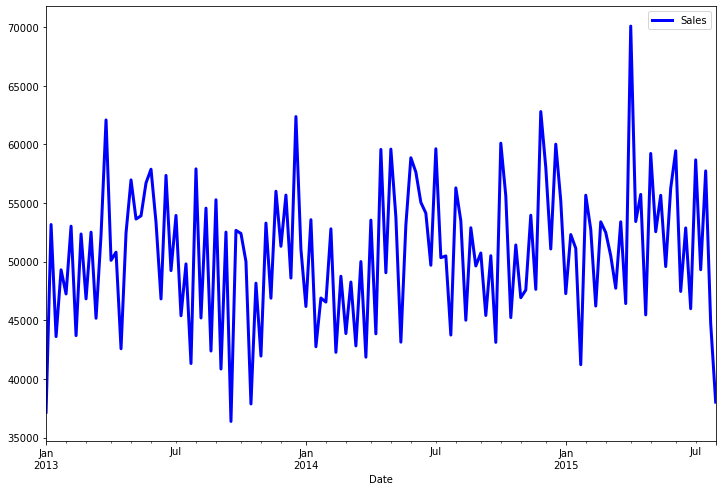

In [13]:
df['Sales'].plot(legend = True, color = 'b', linewidth = 3, figsize = (12,8));

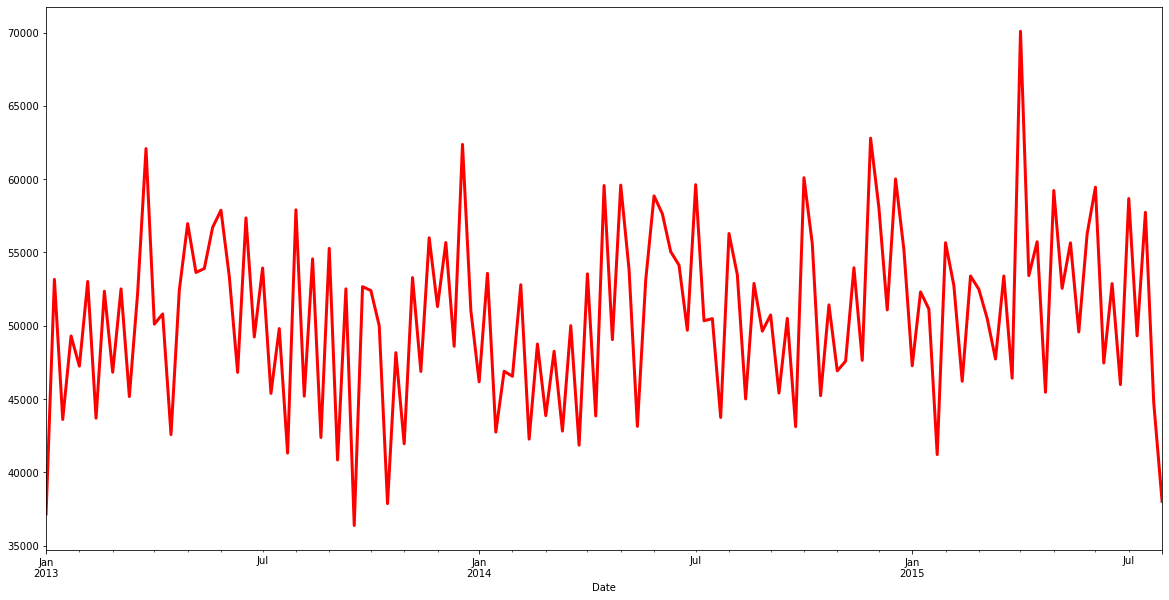

In [14]:
# checking seasonality, trend, resid

plt.figure(linewidth = 3, figsize = (12,8))
res_sd = seasonal_decompose(df['Sales'])
res_sd.observed.plot(color = 'r', linewidth = 3,figsize = (20,10));


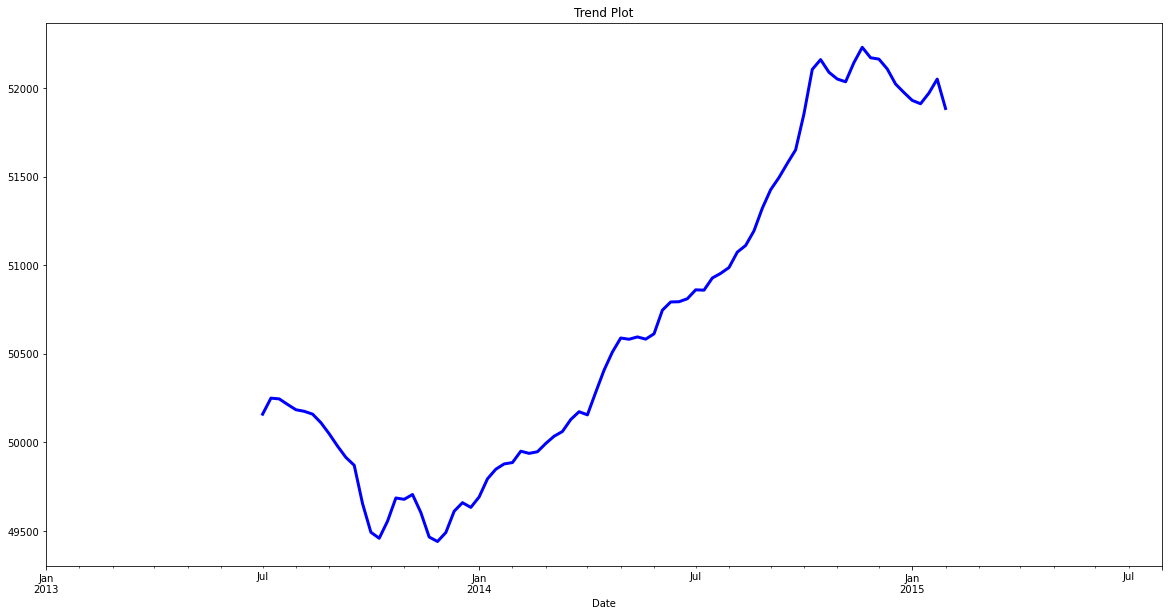

In [15]:
#trend
res_sd.trend.plot(color = 'b', linewidth = 3,figsize = (20,10));
plt.title('Trend Plot');

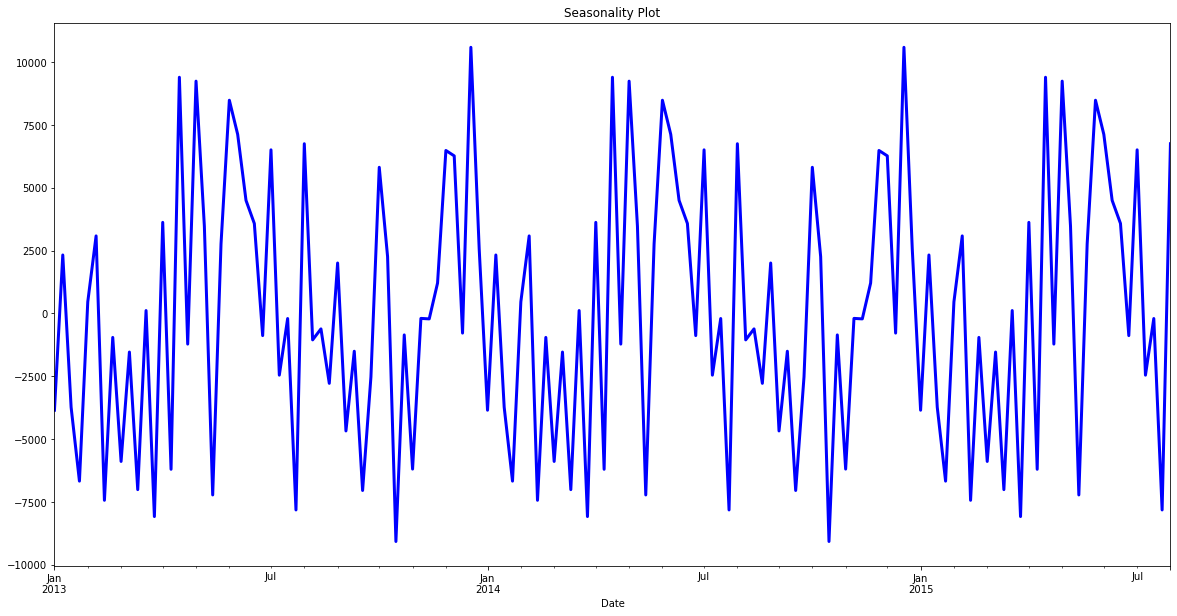

In [16]:
#seasonality plot
res_sd.seasonal.plot(color = 'b', linewidth = 3,figsize = (20,10));
plt.title('Seasonality Plot');

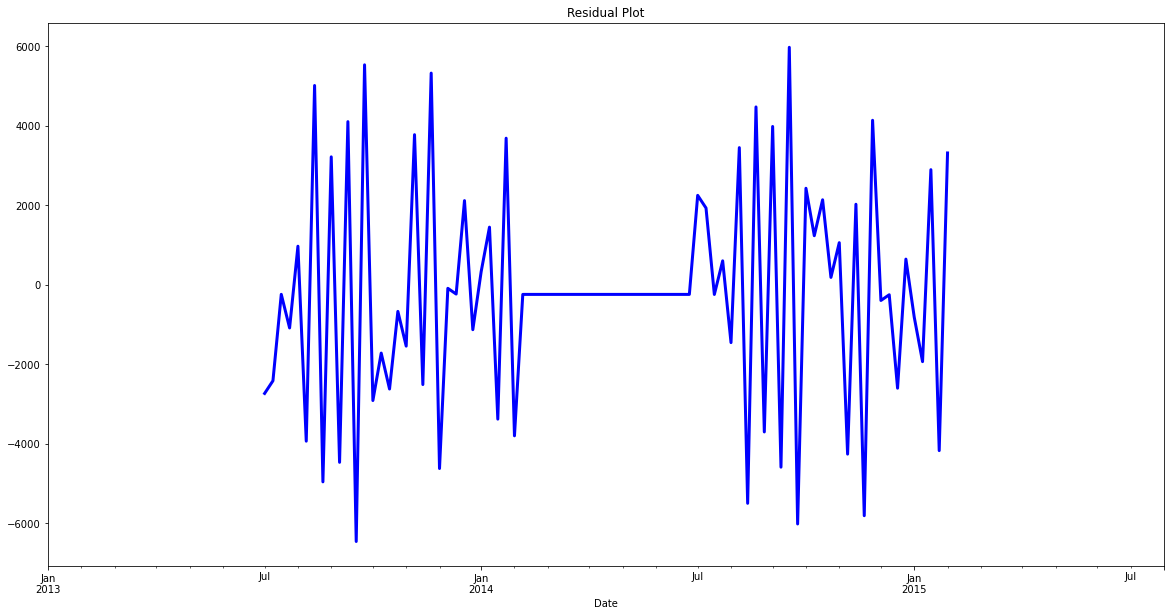

In [17]:
# residual plot
res_sd.resid.plot(color = 'b', linewidth = 3,figsize = (20,10))
plt.title('Residual Plot');

In [18]:
df.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday'],
      dtype='object')

In [19]:
df_sales = df.copy()
df_sales.drop(['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo','SchoolHoliday'], axis =1,inplace = True) 
        
print(df_sales.head())

            Sales
Date             
2013-01-06  37157
2013-01-13  53161
2013-01-20  43603
2013-01-27  49299
2013-02-03  47241


In [20]:
# split the data into train and test

train = df_sales.iloc[:-12] # 16 weeks for test
test = df_sales.iloc[-12:]
print(len(df), len(train), len(test))

135 123 12


In [21]:
# column standarization

sc = MinMaxScaler()

sc.fit(train)
scaled_train = sc.transform(train)
scaled_test  = sc.transform(test)


In [22]:
scaled_train[0:10]

array([[0.02331583],
       [0.49805701],
       [0.21452938],
       [0.383495  ],
       [0.32244668],
       [0.49390407],
       [0.21702115],
       [0.47411824],
       [0.31007683],
       [0.47874581]])

In [23]:
# Time Series Generator
# TimeseriesGenerator?

In [24]:
# create a time series generator

n_input = 6 # 52 features and 53rd will be label
n_features =1
generator = TimeseriesGenerator(scaled_train, scaled_train,
            length = n_input, batch_size =1
            )

In [25]:
len(scaled_train)

123

In [26]:
len(generator)

117

In [27]:
x, y = generator[0]
print(x[0], y)

[[0.02331583]
 [0.49805701]
 [0.21452938]
 [0.383495  ]
 [0.32244668]
 [0.49390407]] [[0.21702115]]


In [28]:
x.shape

(1, 6, 1)

# LSTM Model

In [29]:
#define the LSTM model

model = Sequential()
model.add(LSTM(150, activation = 'relu',input_shape = (n_input, n_features)))#, return_sequences = True)
# model.add(Dropout(0.3))
# model.add(Dense(10, activation = 'relu', kernel_initializer = 'normal'))
# model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss ='mse')

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [31]:
#fit the model
epochs =500 #500
hist = model.fit_generator(generator, epochs = epochs, verbose =0)


In [32]:
hist.history.keys()

dict_keys(['loss'])

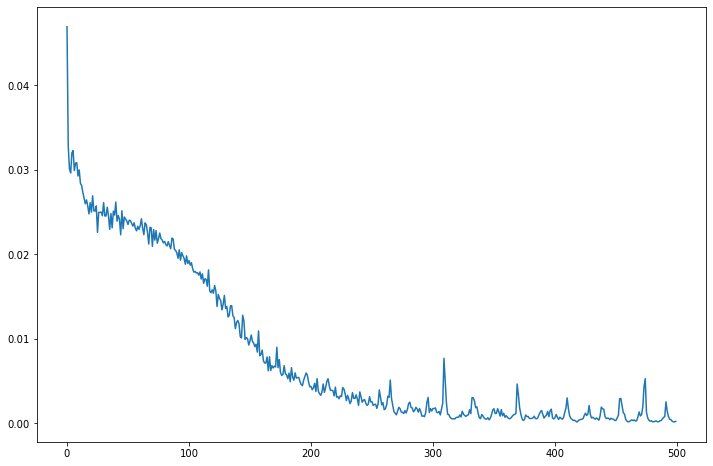

In [33]:
# plot losss
loss_per_epoch = hist.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

# Evaluation and Forecasting

In [34]:
# take the last 12 datapoint to predict future
first_eval_batch = scaled_train[-n_input:]
first_eval_batch

array([[1.        ],
       [0.50559165],
       [0.57429326],
       [0.2694966 ],
       [0.6778203 ],
       [0.47987304]])

In [35]:
# reshape as (1, n_input, n_features)

first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))


In [36]:
model.predict(first_eval_batch)

array([[0.39842814]], dtype=float32)

In [37]:
scaled_test[0]

array([0.5720388])

In [38]:
# x = model.predict(current_batch)
# x[0]

In [39]:
scaled_train.shape


(123, 1)

In [40]:
# this is where we add prediction to the next 12 and will get rid of th first value

test_pred = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input, n_features))
print(current_batch.shape)

for i in range(len(test)):
    # get prediction for the next sample
    current_pred = model.predict(current_batch)[0] # since output is (1,1) shape. we take [0]
    
    # add this prediction to the list
    test_pred.append(current_pred)
    
    #update the current batch 
    current_batch = np.append(current_batch[:, 1:, :],[[current_pred]], axis =1) # our of 12, only 11 is take and added with new current_pred
    
    

(1, 6, 1)


In [41]:
test_pred

[array([0.39842814], dtype=float32),
 array([0.4334608], dtype=float32),
 array([0.39559823], dtype=float32),
 array([0.36845267], dtype=float32),
 array([0.34349415], dtype=float32),
 array([0.40881923], dtype=float32),
 array([0.30375686], dtype=float32),
 array([0.52967834], dtype=float32),
 array([0.44604844], dtype=float32),
 array([0.49676836], dtype=float32),
 array([0.27848375], dtype=float32),
 array([0.62728924], dtype=float32)]

### Inverse Transformation and Comparision

In [42]:
# inverse transformation

true_pred = sc.inverse_transform(test_pred)
true_pred

array([[49802.41109735],
       [50983.39709082],
       [49707.0120241 ],
       [48791.90789735],
       [47950.53119162],
       [50152.70500895],
       [46610.94760451],
       [54226.98667908],
       [51407.73891193],
       [53117.55802786],
       [45758.96564353],
       [57517.54742104]])

In [43]:
test['Prediction'] = true_pred
test.head()

,Sales,Prediction
Date,,
2015-05-17,55655,49802.411097
2015-05-24,49575,50983.397091
2015-05-31,56253,49707.012024
2015-06-07,59449,48791.907897
2015-06-14,47455,47950.531192


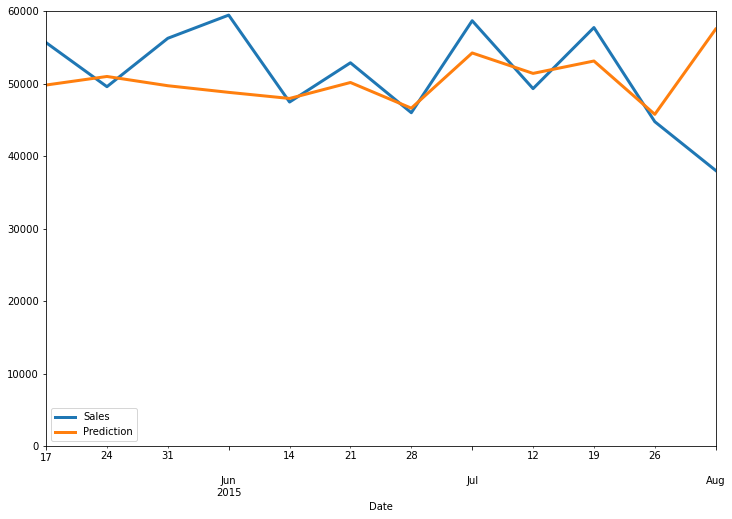

In [44]:
# plott the test and prediction
test.plot(linewidth =3, ylim = (0,60000) );

### save the model for future use.

In [45]:
model.save('rnn_model.h5') # save in h5 format